In [1]:
import time
import os
import sys

import numpy as np
import matplotlib
matplotlib.use('nbagg')
#from matplotlib import style
#style.use('ggplot')
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import stats, wcs
from astropy.io import fits
from astropy.convolution import Gaussian2DKernel
from astropy.coordinates import SkyCoord

from mmtwfs.wfs import *
from mmtwfs.zernike import ZernikeVector
from mmtwfs.telescope import MMT
import poppy
import photutils

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append("/Users/tim/src/cwfs/python")
%cd /Users/tim/MMT/61_inch/20181219/

/Users/tim/MMT/61_inch/20181219


In [4]:
from lsst.cwfs.instrument import Instrument
from lsst.cwfs.algorithm import Algorithm
from lsst.cwfs.image import Image, readFile
import lsst.cwfs.plots as plots

In [5]:
extra_whole = fits.open("rts2focus0012.fits")[1].data # focus = 3190
intra_whole = fits.open("rts2focus0017.fits")[1].data # focus = 1992
#intra = intra_whole[942-18:942+18,158-18:158+18] - np.median(intra_whole)
#extra = extra_whole[945-18:945+18,154-18:154+18] - np.median(extra_whole)
intra = intra_whole[780-35:780+35,503-35:503+35] - np.median(intra_whole)
extra = extra_whole[780-35:780+35,509-35:509+35] - np.median(extra_whole)

<IPython.core.display.Javascript object>


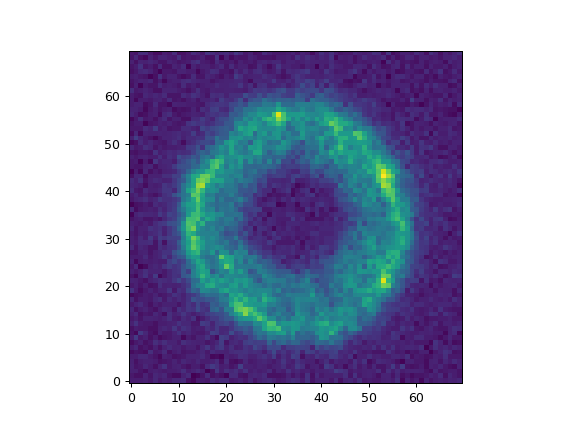

In [6]:
#plt.imshow(intra_whole[942-20:942+20,158-20:158+20], origin="lower")
#plt.imshow(extra_whole[945-20:945+20,154-20:154+20], origin="lower")
plt.imshow(intra, origin="lower")
plt.show()

<IPython.core.display.Javascript object>


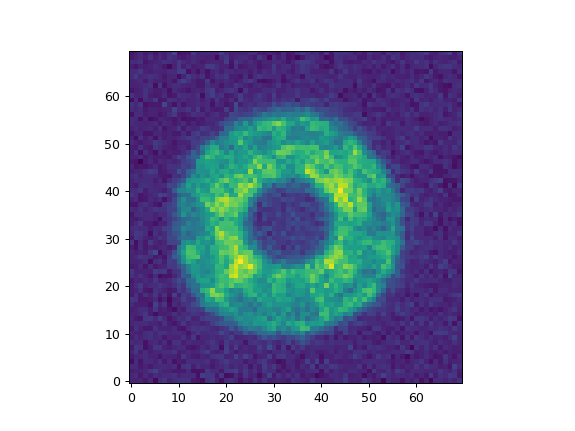

In [7]:
plt.imshow(extra, origin="lower")
plt.show()

In [8]:
fits.writeto("intra.fits", intra, overwrite=True)
fits.writeto("extra.fits", extra, overwrite=True)

These images are binned 3x3 so the pixels are 42 um. Thus the pupil diameter is:

In [57]:
pupsize = 25.25 * 3 * 14
pupsize * u.um

<Quantity 1060.5 um>

The mirror diameter is 1.54 meters and the focal ratio is 13.5. So the focal length is:

In [58]:
diameter = 1.54 * u.m
m1_radius = diameter / 2.
focal_length = diameter * 13.5
focal_length

<Quantity 20.79 m>

Calculate the angle of beam convergence:

In [59]:
ang = np.arctan2(m1_radius, focal_length)
ang

<Quantity 0.03702012 rad>

In [60]:
offset = pupsize / np.tan(ang) * u.um
offset

<Quantity 28633.5 um>

In [61]:
def kuiper_focus(pup_rad, focus, binning=3, direction='out'):
    pupsize = 14 * binning * pup_rad * u.um
    diameter = 1.54 * u.m
    radius = diameter / 2
    focal_length = diameter * 13.5
    beam_ang = np.arctan2(radius, focal_length)
    offset = pupsize / np.tan(beam_ang) * u.um
    counts_per_um = 600. / 28633.5  # empirically determined
    correction = offset.value * counts_per_um
    if 'out' in direction:
        correction *= -1
    return focus + correction

In [62]:
kuiper_focus(25.25, 3190, direction='out')

2590.0

So about 14 mm of focus offset at focal plane for 300 counts of focus change which gives 20 counts/mm. For motion at the secondary, scale by the ratio of the squares of the focal ratios:

In [63]:
counts_per_mm = 600. / offset.to(u.mm).value
counts_per_mm_m2 = counts_per_mm / (13.5**2 / 4.**2)
counts_per_mm, counts_per_mm_m2

(20.954476400020955, 1.8396248142679577)

In [64]:
obscuration = 0.4096 / 1.54
obscuration

0.265974025974026

In [65]:
nmperrad = m1_radius.to(u.nm).value
nmperasec = nmperrad / 206265.
nmperasec

3733.061837926938

In [66]:
fieldXY = [0., 0.]
I1 = Image(readFile("intra.fits"), fieldXY, Image.INTRA)
I2 = Image(readFile("extra.fits"), fieldXY, Image.EXTRA)

<IPython.core.display.Javascript object>


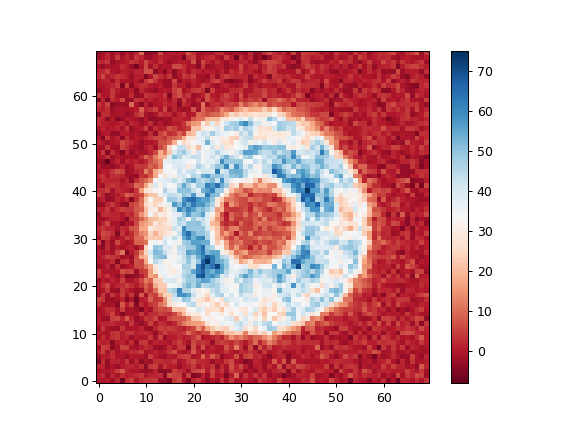

In [67]:
fig, ax = plt.subplots()
im = ax.imshow(I2.image, origin='lower', cmap='RdBu')
cbar = fig.colorbar(im)
fig.show()

In [20]:
kuiper = Instrument('61inch', I1.sizeinPix)

In [21]:
#kuiper.offset = offset.to(u.m).value  # needs to be focus offset between intra and extra positions
kuiper.offset

0.028634

In [110]:
algo = Algorithm('exp.focus', kuiper, 3)

In [111]:
algo.runIt(kuiper, I1, I2, 'onAxis')

resetting images: I1 and I2
resetting images, inside
imageCoCenter: (x1,y1)=(   35.43,   35.70)

imageCoCenter: (x1,y1)=(   35.23,   35.72)

itr = 0, z4-z4
[-311.]
itr = 1, z4-z4
[-364.]
itr = 2, z4-z4
[-401.]
itr = 3, z4-z4
[-416.]
itr = 4, z4-z4
[-427.]
itr = 5, z4-z4
[-433.]
itr = 6, z4-z4
[-444.]
itr = 7, z4-z4
[-443.]
itr = 8, z4-z4
[-443.]
itr = 9, z4-z4
[-455.]
itr = 10, z4-z4
[-451.]
itr = 11, z4-z4
[-448.]
itr = 12, z4-z4
[-446.]
itr = 13, z4-z4
[-456.]
itr = 14, z4-z4
[-452.]


In [112]:
print(algo.zer4UpNm)

[-452.08830703]


In [25]:
plots.plotZer(algo.zer4UpNm, 'nm')

In [113]:
zv = ZernikeVector()
zv.from_array(algo.zer4UpNm, modestart=4, normalized=True)
zv.denormalize()
zv

Fringe Coefficients
 Z04:                  -783 nm 	 Defocus (2, 0)

Total RMS: 	 452.1 nm

<IPython.core.display.Javascript object>


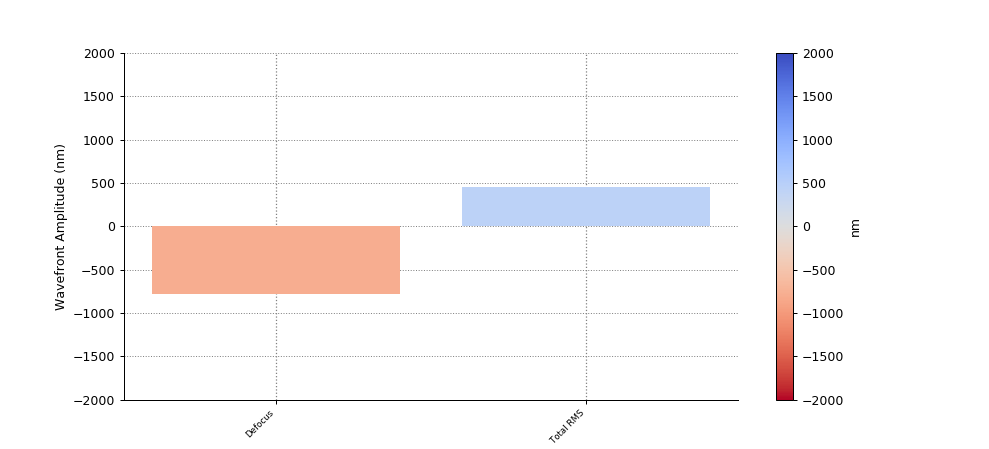

In [114]:
zv.fringe_bar_chart().show()
plt.show()

<IPython.core.display.Javascript object>


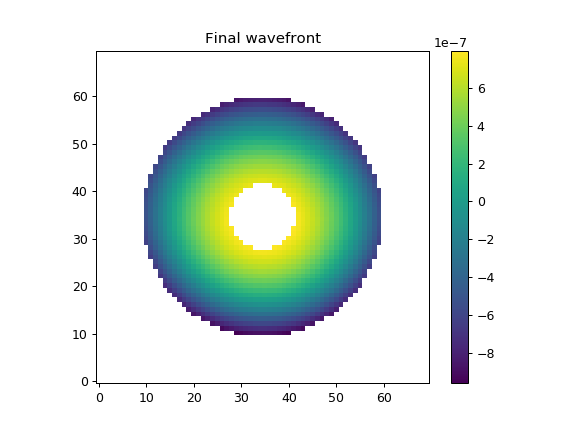

In [105]:
plots.plotImage(algo.Wconverge, "Final wavefront", show=True)

<IPython.core.display.Javascript object>


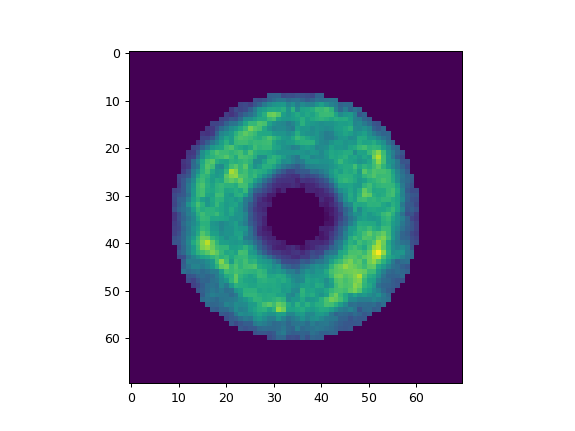

In [106]:
plt.imshow(algo.image)
plt.show()

In [ ]:
plt.close('all')

Scaling seems wrong so try to calculate offset for MMT same way...

In [30]:
pupsize = 135. * 26.
mmt_diameter = 6.5 * u.m
mmt_radius = diameter / 2.
mmt_focal_length = mmt_diameter * 5.3
ang = np.arctan2(mmt_radius, mmt_focal_length)
mmt_offset = 0.5 * pupsize / np.tan(ang) * u.um
mmt_offset

<Quantity 18603. um>

OK, this matches what we're using there.

Use the Z04 term from the CWFS fit and see if we can calculate a focus correction

In [115]:
# this calculates the difference in size between in-focus pupil and observed in um
foc_err = (zv['Z04'] / (nmperasec * u.nm / u.arcsec)) * (100 * u.um / u.arcsec)

# use the tangent of the beam angle to convert pupil size difference to shift in focus position at focal plane.
# convert to focus counts and negate to create correction to send to telescope.
foc_corr = -counts_per_mm * foc_err.to(u.mm).value / np.tan(ang)
foc_corr

<Quantity 11.8675015>

In [32]:
hdulist_ex = fits.open("rts2focus0012.fits")
hdulist_in = fits.open("rts2focus0017.fits")
hdulist = hdulist_ex

In [33]:
h = hdulist[0].header
h['EPOCH'] = float(h['EPOCH'])
h['EQUINOX'] = float(h['EQUINOX'])
w1 = wcs.WCS(hdulist[1].header)
w2 = wcs.WCS(hdulist[2].header)

In [34]:
w1

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 120.8796666666667  27.79427777777778  
CRPIX : 682.3333333333334  682.3333333333334  
CD1_1 CD1_2  : 0.000119166  -0.0  
CD2_1 CD2_2  : 0.0  0.000119166  
NAXIS : 702  1365

In [35]:
w2

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 120.8796666666667  27.79427777777778  
CRPIX : 681.3333333333334  682.3333333333334  
CD1_1 CD1_2  : -0.000119166  -0.0  
CD2_1 CD2_2  : -0.0  0.000119166  
NAXIS : 702  1365

In [36]:
hdulist.info()

Filename: rts2focus0012.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     100   ()      
  1  IM1           1 ImageHDU        71   (702, 1365)   int16 (rescales to uint16)   
  2  IM2           1 ImageHDU        71   (702, 1365)   int16 (rescales to uint16)   


<IPython.core.display.Javascript object>


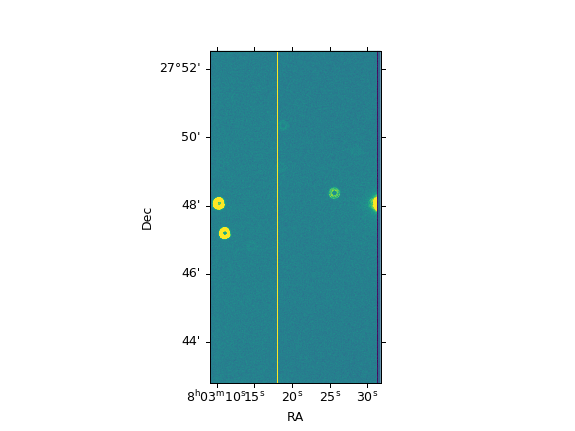

In [37]:
hdu = hdulist[1]
w = wcs.WCS(hdu.header)
im = hdu.data
norm = wfs_norm(im)
plt.subplot(projection=w)
plt.imshow(im, origin='lower', norm=norm)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

In [38]:
threshold = photutils.detect_threshold(im, snr=2)
sigma = 10 * stats.gaussian_fwhm_to_sigma
kernel = Gaussian2DKernel(sigma, x_size=15, y_size=15)
kernel.normalize()
segm = photutils.detect_sources(im, threshold, npixels=25, filter_kernel=kernel)

<IPython.core.display.Javascript object>


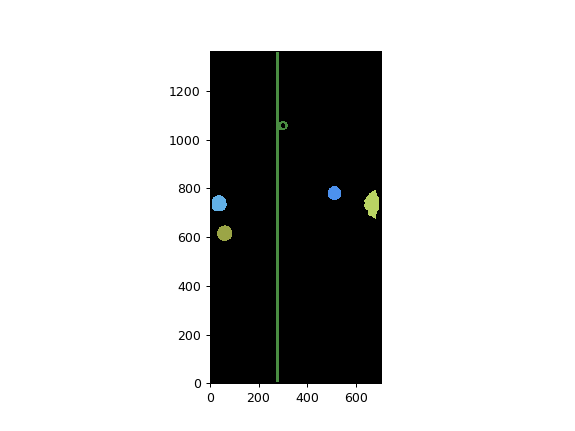

In [39]:
plt.imshow(segm, origin='lower', cmap=segm.cmap(random_state=12345))
plt.show()

In [40]:
cat = photutils.source_properties(im, segm, wcs=w)

In [41]:
cat.to_table()

id,xcentroid,ycentroid,sky_centroid,sky_centroid_icrs,source_sum,source_sum_err,background_sum,background_mean,background_at_centroid,xmin,xmax,ymin,ymax,min_value,max_value,minval_xpos,minval_ypos,maxval_xpos,maxval_ypos,area,equivalent_radius,perimeter,semimajor_axis_sigma,semiminor_axis_sigma,eccentricity,orientation,ellipticity,elongation,covar_sigx2,covar_sigxy,covar_sigy2,cxx,cxy,cyy
,pix,pix,"deg,deg","deg,deg",,,,,,pix,pix,pix,pix,,,pix,pix,pix,pix,pix2,pix,pix,pix,pix,,rad,,,pix2,pix2,pix2,1 / pix2,1 / pix2,1 / pix2
int64,float64,float64,object,object,uint64,object,object,object,object,float64,float64,float64,float64,uint16,uint16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,275.858661623823,695.3764357573914,"120.82504534719641,27.795940497894794","120.8250393349743,27.795946540076063",22060569,None,None,None,None,268.0,317.0,5.0,1359.0,980,2387,273.0,28.0,275.0,663.0,21101.0,81.9552128199553,2866.4091629284894,389.73515191933643,6.317360110988157,0.999868619580292,1.5687621125394284,0.983790632998135,61.6927237124645,40.537412214362575,308.9018642072979,151892.8602681458,0.025056876683517113,-0.00010191546732462589,6.687219775379291e-06
2,59.18672077570068,613.5917603958858,"120.79586511103246,27.786180010502555","120.79585909704475,27.786186053020117",3385017,None,None,None,None,29.0,89.0,583.0,645.0,987,1310,57.0,583.0,68.0,623.0,3113.0,31.478543099866304,206.50966799187808,15.751390733103857,15.235242426450501,0.25389581589712507,-1.463507612185461,0.03276842758833953,1.0338785752274773,232.296007840893,-1.7028056088051504,247.92291397873444,0.004305069030731645,5.913689520809671e-05,0.004033714888508463
3,667.7095235189896,733.8017412932649,"120.8778313312061,27.800530215928532","120.87782532198659,27.800536257497495",7441136,None,None,None,None,626.0,689.0,673.0,790.0,927,22751,684.0,706.0,679.0,730.0,4867.0,39.360058638885555,310.2497833620557,22.25833708664408,14.74896256456216,0.7489500697215896,1.5264203149909121,0.3373735644693715,1.5091459476699027,218.07879003262508,12.315984382204524,494.8866765609061,0.0045919524765577445,-0.00022855501133359126,0.002023508587731772
4,36.23766669724023,735.3757786358246,"120.79276233489281,27.80069060902466","120.79275632094576,27.800696651577884",3914057,None,None,None,None,7.0,67.0,703.0,768.0,985,1644,55.0,761.0,26.0,727.0,3331.0,32.56209807242474,213.6812408671319,16.33518720690718,15.218485822651571,0.3633869875521162,-1.5290694690773134,0.06836171328256468,1.073377956077173,231.66362566868403,-1.468582775868668,266.77702615026686,0.004316754067590393,4.7526661218222216e-05,0.0037485795266896135
5,507.1316277266301,777.9498208647982,"120.85619789910588,27.805789194752144","120.85619188876164,27.805795236572674",2537748,None,None,None,None,480.0,535.0,751.0,806.0,985,1065,480.0,772.0,497.0,770.0,2495.0,28.18125557934844,183.6812408671319,14.07743769527876,14.03663949846927,0.07607794743273816,0.26259082998688354,0.002898126611718066,1.002906550162091,198.0969628731662,0.28753672073212766,197.10453760127683,0.005048043659760717,-1.4728204004886853e-05,0.005073460660112489


In [42]:
cat[0]['sky_centroid']

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (120.82504535, 27.7959405)>

In [ ]:
def find_donuts(extra_fits, intra_fits, snr=2, fwhm=10, ksize=15):
    threshold = photutils.detect_threshold(im, snr=snr)
    sigma = fwhm * stats.gaussian_fwhm_to_sigma
    kernel = Gaussian2DKernel(sigma, x_size=ksize, y_size=ksize)
    kernel.normalize()
    hdulist_ex = fits.open("extra.fits")
    hdulist_in = fits.open("intra.fits")
    images = {}
    for foc in ['intra', 'extra']:
        images[foc] = {}
    images['extra']['left'] = hdulist_ex[1]
    images['extra']['right'] = hdulist_ex[2]
    images['intra']['left'] = hdulist_in[1]
    images['intra']['right'] = hdulist_in[2]

In [70]:
type(10 * u.deg)

astropy.units.quantity.Quantity

In [71]:
u.Quantity

astropy.units.quantity.Quantity

In [72]:
(1 * u.rad).to(u.arcsec).value

206264.80624709636

In [74]:
c = u.rad / u.arcsec

In [76]:
type(c.decompose())

astropy.units.core.CompositeUnit

In [83]:
c.compose().value

AttributeError: 'list' object has no attribute 'value'

In [85]:
im = readFile("/Users/tim/src/cwfs/tests/testImages/F1.23_1mm_v61/z7_0.25_extra.txt")

In [86]:
im.shape

(120, 120)

In [88]:
algo.numTerms = 5
algo.numTerms

5

In [93]:
algo.ZTerms

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22])